# Piperoni - Tools for Authoring Data Pipelines


###  Piperoni Objectives
1. Offer a framework for authoring data pipelines that are **modular** and **readable**.
2. Implement a common suite of tools that are common in DE work (**tested components**).

### Types of Data
- Prior customer work has shown that **tabular** data is the most prevalant source of data


### Basis of Piperoni - Three Base Python Objects
- **Operator** - Atomic unit for transforming data. There are three base Operator classes: CastOperator, TransformOperator and PassthroughOperator. CastOperator is for operations that change the data type, TransformOperator requires input and output data types to be the same, and PassthroughOperator is for operations that do not modify the data. Some common operations include:
  - *Extract* - from CSV, JSON, and Excel files
  - *Transform* - map csv headers, featurize a dataset
  - *Load* - save data to a checkpoint file, upload objects to the platform
  - *Validation* - checks on data to ensure quality
- **Pipe** - Chains several operators together in a linear (single in/single out) fashion.
- **Pipeline** - Aggregate several pipes together with support for branching and caching.

### Example Data Pipeline - Ingest Local Files to the Citrine Platform
Strellow and Cook Dataset: bandgaps on 1450 inorganic materials.

Procurement | Identity | Measurement | Band gap | uncertainty in band gap | Crystallinity | Color
---|---|---|---|---|---|---|
Purchased | BeO | General Measurement | 14.5 | 0 | | 
Purchased | LiF | General Measurement | 13.6 | 0 | Single crystalline |

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# loads pre-built operators from the piperoni library

from piperoni.operators.transform_operator import TransformOperator
from piperoni.operators.cast_operator import CastOperator
from piperoni.operators.passthrough_operator import PassthroughOperator

from piperoni.operators.extract.extract_file.csv_ import CSVExtractor
from piperoni.operators.transform.assign_uids_operator import AssignUIDsOperator
from piperoni.operators.transform.transform_name.header_map import HeaderMap
from piperoni.operators.pipe import Pipe
from piperoni.operators.pipeline import Pipeline, PipelineData

import logging
import pandas as pd

In [3]:
class SigmaOutlierDetector(PassthroughOperator):

    def __init__(self, sigmas=4, stop_execution=False):
        super().__init__()
        self.sigmas = sigmas
        self.stop_execution=stop_execution
        
    def test_equals(self, input_, output_):
        return input_.equals(output_)

    def transform(self, df):
        stats = df.describe().loc[["mean", "std"]]

        # get allowed upper and lower bound of each column
        bounds = dict()
        for col in stats:
            bounds[col] = {
                "upper": stats.loc["mean", col]
                + stats.loc["std", col] * self.sigmas,
                "lower": stats.loc["mean", col]
                - stats.loc["std", col] * self.sigmas,
            }

        # collect outliers
        outliers = dict()
        for col in stats:
            for val in df[col]:
                if val > bounds[col]["upper"] or val < bounds[col]["lower"]:
                    if col in outliers:
                        outliers[col].append(val)
                    else:
                        outliers[col] = [val]

        if outliers:
            if self.stop_execution:
                raise ValueError("Outliers have been detected in your dataframe.")
            else:
                self.logger.info('Outliers!!')
        return df
            
            

In [11]:
# This should cause an error!

pipe_steps = [
    CSVExtractor(),
    AssignUIDsOperator('sc-uids', unique_prepend=''),
    SigmaOutlierDetector(sigmas=6, stop_execution=True),
    HeaderMap.from_yaml('../test_files/Strehlow and Cook map.yaml', complete_map=False),
]

pipe = Pipe(
    steps=pipe_steps,
    name='My pipe',
    file_logging_level=10,
    uid_column = 'sc-uids',
    autocheckpoint = True,
    autocompare= False,
    logging_path = '/Users/esevgen/Citrine/Projects/'
)
gems = pipe("Strehlow and Cook.csv")

2020-12-15_13.21.36 - My pipe - Pipe: Pipe initialized.
2020-12-15_13.21.36 - My pipe - Pipe: The pipe consists of the following transforms:
2020-12-15_13.21.36 - My pipe - Pipe: CSVExtractor
2020-12-15_13.21.36 - My pipe - Pipe: AssignUIDsOperator
2020-12-15_13.21.36 - My pipe - Pipe: SigmaOutlierDetector
2020-12-15_13.21.36 - My pipe - Pipe: HeaderMap
2020-12-15_13.21.36 - My pipe - Pipe: Starting execution of pipe.
  2020-12-15_13.21.36 - My pipe - CSVExtractor: Applying transform
  2020-12-15_13.21.36 - My pipe - CSVExtractor: Applied transform
  2020-12-15_13.21.36 - My pipe - Checkpoint: Applying transform
  2020-12-15_13.21.36 - My pipe - Checkpoint: Applied transform
  2020-12-15_13.21.36 - My pipe - AssignUIDsOperator: Applying transform
  2020-12-15_13.21.36 - My pipe - AssignUIDsOperator: Applied transform
  2020-12-15_13.21.36 - My pipe - Checkpoint: Applying transform
  2020-12-15_13.21.36 - My pipe - Checkpoint: Applied transform
  2020-12-15_13.21.36 - My pipe - SigmaOut

ValueError: Outliers have been detected in your dataframe.

In [5]:
class FixBandgapUnits(TransformOperator):
    """Deals with Bandgap outliers in S&C.

    Reduces outliers by a factor of 1000. A materials
    scientist used meV insead of eV for some of the entries.

    Parameters
    ----------
    column: string
        The column to fix outliers.
    threshold: float
        The threshold, above which outliers are fixed.
    """

    def __init__(self, column, threshold=50):
        self.column = column
        self.threshold = threshold

    def transform(self, df):
        """Reduces outliers by a factor of 1000.

        Parameters
        ----------
        df: DataFrame
            Input dataframe that may contain outliers.

        Returns
        -------
        DataFrame
            Has the outliers reduced by a factor of 1000.
        """
        original_values = df[self.column]

        # collects transformed values
        transformed_values = []
        for val in original_values:
            if val >= self.threshold:
                val = val / 1000
            transformed_values.append(val)

        # returns edited version of df
        df[self.column] = transformed_values
        return df

In [6]:
pipe_fixed_units = Pipe(
    [
        CSVExtractor(),
        AssignUIDsOperator('sc-uids', unique_prepend=''),
        FixBandgapUnits(
            column='Band gap',
            threshold=50,
        ),
        SigmaOutlierDetector(sigmas=6, stop_execution=False),
        HeaderMap.from_yaml('../test_files/Strehlow and Cook map.yaml', complete_map=False),
    ],
    name='My pipeline',
    uid_column = 'sc-uids',
    autocheckpoint=False,
)
gems = pipe_fixed_units("Strehlow and Cook.csv")

2020-12-15_13.20.33 - My pipeline - Pipe: Pipe initialized.
2020-12-15_13.20.33 - My pipeline - Pipe: The pipe consists of the following transforms:
2020-12-15_13.20.33 - My pipeline - Pipe: CSVExtractor
2020-12-15_13.20.33 - My pipeline - Pipe: AssignUIDsOperator
2020-12-15_13.20.33 - My pipeline - Pipe: FixBandgapUnits
2020-12-15_13.20.33 - My pipeline - Pipe: SigmaOutlierDetector
2020-12-15_13.20.33 - My pipeline - Pipe: HeaderMap
2020-12-15_13.20.33 - My pipeline - Pipe: Starting execution of pipe.
  2020-12-15_13.20.33 - My pipeline - CSVExtractor: Applying transform
  2020-12-15_13.20.33 - My pipeline - CSVExtractor: Applied transform
  2020-12-15_13.20.33 - My pipeline - AssignUIDsOperator: Applying transform
  2020-12-15_13.20.33 - My pipeline - AssignUIDsOperator: Applied transform
  2020-12-15_13.20.33 - My pipeline - FixBandgapUnits: Applying transform
  2020-12-15_13.20.33 - My pipeline - FixBandgapUnits: Applied transform
  2020-12-15_13.20.33 - My pipeline - SigmaOutlierD

### Future Features

1. Framework for **packaging domain-specific transformations**
2. Support for **logging** errors, warnings, and transformation steps
3. Support **branching pipelines** (ex. creating a master datasheet from a series of datafiles)

### Feedback

#### Could you execute a jumpstart with this framework? If not, what is missing?
1. How useable is the Framework's UX?
2. How useful could this be for customers making pipelines?

#### What built-in features should we add?
1. Additional outlier detectors?
2. Common featurizers?
3. Logs? Pipeline visualization?

#### Are you bought-in on the framework vs library aspect?

# Thank-you!

In [7]:
# Try something more complicated
# Connected pipeline with logging from pipes


class IncrementOperator(TransformOperator):

    def transform(self, input_):
        self.logger.info(f'Received {input_}, passing {input_+1}.')
        return input_ + 1
    
    
class SumOperator(CastOperator):

    @property
    def input_type(self): 
        return PipelineData
    
    @property
    def output_type(self):
        return int

    def transform(self, input_):
        to_sum = list(input_.values())
        self.logger.info(f'Summing {to_sum}, returning {sum(to_sum)}.')
        return sum(to_sum)
    
class OneVsRestSplitOperator(CastOperator):
        
    @property
    def input_type(self): 
        return int
    
    @property
    def output_type(self):
        return PipelineData
    
    def __init__(self, name):
        self.name = name

    def transform(self, input_):
        self.logger.info(f'Received {input_}, splitting into {1} and {input_-1}.')
        return PipelineData(**{f'{self.name}_output1': 1, f'{self.name}_output2': input_-1})

In [8]:
pipe1 = Pipe(
    name='Pipe1',
    steps=[IncrementOperator(),
    IncrementOperator(),
    IncrementOperator()])

pipe2 = Pipe(
    name='Pipe2',
    steps=[SumOperator(),
    IncrementOperator(),
    OneVsRestSplitOperator('pipe2')])

pipe3 = Pipe(
    name='Pipe3',
    steps=[SumOperator(),
    OneVsRestSplitOperator('pipe3')])




# ----------------------------------------

inputs = {
    pipe1: 'pipe1_raw',
    pipe2: ['pipe1_output', 'pipe2_raw'],
    pipe3: ['pipe1_output', 'pipe2_output1', 'pipe3_raw']
}

outputs = {
    pipe1: 'pipe1_output',
    pipe2: ['pipe2_output1', 'pipe2_output2'],
    pipe3: ['pipe3_output1', 'pipe3_output2']
}

raws = {
    'pipe1_raw': 3,
    'pipe2_raw': 7,
    'pipe3_raw': 13
}

pipeline = Pipeline(inputs, outputs, raws)
pipeline.run()

2020-12-15_13.20.33 - Pipe1 - Pipe: Pipe initialized.
2020-12-15_13.20.33 - Pipe1 - Pipe: The pipe consists of the following transforms:
2020-12-15_13.20.33 - Pipe1 - Pipe: IncrementOperator
2020-12-15_13.20.33 - Pipe1 - Pipe: IncrementOperator
2020-12-15_13.20.33 - Pipe1 - Pipe: IncrementOperator
2020-12-15_13.20.33 - Pipe2 - Pipe: Pipe initialized.
2020-12-15_13.20.33 - Pipe2 - Pipe: The pipe consists of the following transforms:
2020-12-15_13.20.33 - Pipe2 - Pipe: SumOperator
2020-12-15_13.20.33 - Pipe2 - Pipe: IncrementOperator
2020-12-15_13.20.33 - Pipe2 - Pipe: OneVsRestSplitOperator
2020-12-15_13.20.33 - Pipe3 - Pipe: Pipe initialized.
2020-12-15_13.20.33 - Pipe3 - Pipe: The pipe consists of the following transforms:
2020-12-15_13.20.33 - Pipe3 - Pipe: SumOperator
2020-12-15_13.20.33 - Pipe3 - Pipe: OneVsRestSplitOperator
2020-12-15_13.20.33 - Pipe1 - Pipe: Starting execution of pipe.
  2020-12-15_13.20.33 - Pipe1 - IncrementOperator: Applying transform
  2020-12-15_13.20.33 - P

{'pipe3_output2': 19, 'pipe2_output2': 13, 'pipe3_output1': 1}

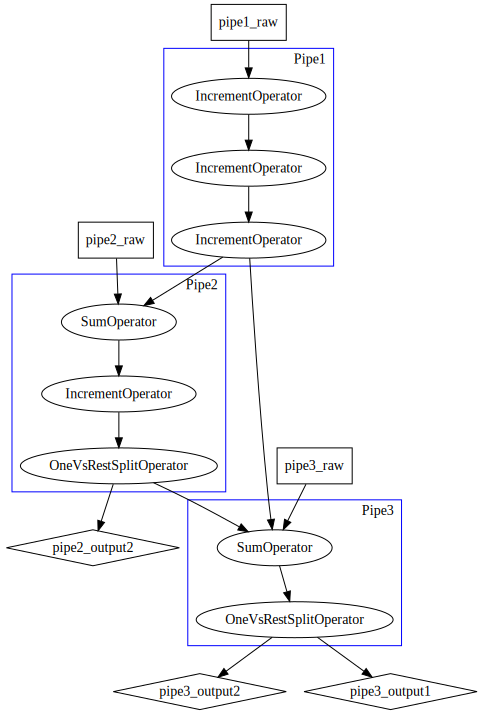

In [10]:
pipeline.visualize(True)